In [1]:
import sys
sys.path.append('..')
import torch
import pennylane as qai
import time
import gpytorch


# Related package

import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian related
from openfermion.chem import MolecularData
import openfermion
from openfermionpyscf import run_pyscf

# MISC
r_bohr = 0.529177210903

# Global variable
n_qubits = 4
n_layers = 3
n_search = 150
n_experts = 5

# 
tolerance = 1e-6
min_pass = 5

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev1 = qai.device("default.qubit", wires=n_qubits)

In [2]:
import itertools


valid_Rs =  [qai.RY, qai.RZ]
valid_CNOTs = ([0, 1], [1, 2], [2, 3])

Rs_space = list(itertools.product(valid_Rs, valid_Rs, valid_Rs, valid_Rs))
CNOTs_space = [[y for y in CNOTs if y is not None] for CNOTs in list(itertools.product(*([x, None] for x in valid_CNOTs)))]
NAS_search_space = list(itertools.product(Rs_space, CNOTs_space))

In [3]:
len(NAS_search_space)

128

In [4]:
NAS_search_space[3][1]

[[0, 1]]

In [5]:
class CircuitSearchModel():
    def __init__(self, n_qubits=4, n_layers=3, n_experts=5):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_experts = n_experts
        '''init params'''
        # randomly initialize parameters from a normal distribution
        self.params_space = np.random.uniform(0, np.pi * 2, (n_experts, n_layers, len(Rs_space), n_qubits))
        self.params = torch.ones((3,4), requires_grad=True)
    
    def get_params(self, subnet, expert_idx):
        self.subnet = subnet
        self.expert_idx = expert_idx
        params = []
        # print("CNOT", NAS_search_space)
        # print("get", subnet, expert_idx)
        for j in range(self.n_layers):
            r_idx = subnet[j] // len(CNOTs_space)
            params.append(self.params_space[expert_idx, j, r_idx:r_idx+1][0])
        self.params=torch.tensor(params, requires_grad=True)
        return np.concatenate(params, axis=0)

    def set_params(self):
        self.params = self.params.cpu().detach().numpy()
        for j in range(self.n_layers):
            r_idx = self.subnet[j] // len(CNOTs_space)
            # print("set", j, self.subnet[j], r_idx, len(CNOTs_space))
            # print("set", self.params_space)
            self.params_space[self.expert_idx, j, r_idx:r_idx+1] = self.params[j, :]

    def __call__(self, params, wires):
        circuit_search(params, wires=wires,
                       n_qubits=self.n_qubits,
                       n_layers=self.n_layers,
                       arch=self.subnet)

In [6]:
# Hamiltonian


def get_H2_hamiltonian(distance):
    bond_length=distance*r_bohr
    geometry = [('H', (0., 0., -bond_length/2)), ('H', (0., 0., bond_length/2))]
    molecule = MolecularData(
        geometry, basis, multiplicity,charge=0,
        description=str(round(bond_length, 2)))
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    terms_molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[], active_indices=[0,1])
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    jw_hamiltonian = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)
#     print(jw_hamiltonian.terms)
#     print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#     print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

    return jw_hamiltonian.terms, molecule.fci_energy


In [7]:
AIdList = []

# Ansatz

def ansatz(params, AIdList):
    for i, Aid in enumerate(AIdList):
        for j in range(n_qubits):
            NAS_search_space[Aid][0][j](params[i][j], wires=[j])
        for cnot_pair in NAS_search_space[Aid][1]:
            qai.CNOT(wires=list(cnot_pair))

In [8]:

def getGateFromName(name):
    if name=="I":
        return qai.Identity
    if name=="X":
        return qai.PauliX
    if name=="Y":
        return qai.PauliY
    if name=="Z":
        return qai.PauliZ
def measurements(gatesPrefix):
    obs = None
    for qubit, gatePrefix in list(gatesPrefix):
        gate = getGateFromName(gatePrefix)
        if obs == None:
            obs = gate(qubit)
        else:
            obs = obs @ gate(qubit)
    if obs == None:
        obs = qai.Identity(0)
    return qai.expval(op=obs)
def initCircuit(distance, circDefList):
    def circuitDefTemplate(params, obsStr, AIdList):
        ansatz(params, AIdList)
        return  measurements(obsStr)
    H, fci_energy = get_H2_hamiltonian(distance)
    
    for i, idx in enumerate(H):
        weightList.append(H[idx])
        circDefList.append(idx)
        
    circ = qai.QNode(circuitDefTemplate, dev1, interface='torch', diff_method="backprop")
    return (circ, fci_energy)


In [9]:
def expert_evaluator(model, subnet, n_experts, cost_fn):

    target_expert = 0
    target_loss = None
    for i in range(n_experts):
        model.params = model.get_params(subnet, i)
        temp_loss = cost_fn(model.params)
        if target_loss is None or temp_loss < target_loss:
            target_loss = temp_loss
            target_expert = i
    return target_expert

In [10]:
import torch.nn as nn

distList = np.arange(0.5,1.0, 0.5)
energyList = np.array([])
timeList = np.array([])
fciEnergyList = np.array([])
modelParam = CircuitSearchModel()

timestamp = np.array([])
error = np.array([])

distance = 1.2



In [11]:
step_size = 0.2


time_start=time.time()    


for i_iter in range(n_search):
    circDefList = []
    compiledCircList = []
    weightList = []
    selectedAIdList = np.random.randint(0, len(NAS_search_space), (n_layers,)).tolist()
    
    circ, fciE = initCircuit(distance, circDefList)
    
#     find optimal expert
    expert_idx = np.random.randint(n_experts)
    if i_iter>100:
        for i in range(n_experts):
            # get params
            min_loss = 100000
            min_expert_id = 0
            params = modelParam.get_params(selectedAIdList, i)

            # calculate
            exp = 0
            for idx, circDef in enumerate(circDefList):   
                psi_H_psi = circ(modelParam.params, circDef, selectedAIdList)
                exp += psi_H_psi.real*weightList[idx].real
    #             print(psi_H_psi.real, weightList[idx])
            loss = exp
            if loss<min_loss:
                min_loss = loss
                min_expert_id = i
        expert_idx = min_expert_id
    # get params
    modelParam.get_params(selectedAIdList, expert_idx)
#     params = torch.zeros((3,4))
    vNgdOpt = torch.optim.Adam([modelParam.params], lr=0.9)
    
    # for each set
    l_sum = 0
    loss = nn.L1Loss()
    exp = 0
    for idx, circDef in enumerate(circDefList):   
        psi_H_psi = circ(modelParam.params, circDef, selectedAIdList)
        exp += psi_H_psi.real*weightList[idx].real


    l = loss(exp, torch.Tensor([-100.]))
    l.backward()        
#     optimizer.step()
#     optimizer.zero_grad()
#     params = opt.step(cost, params)
#     print("old", modelParam.params)
    vNgdOpt.step()
#     print("new", modelParam.params)
#     print("grad", modelParam.params.grad)
    vNgdOpt.zero_grad()

    # set params
    modelParam.set_params()
        
        
#     print(params)
    print(i_iter, selectedAIdList, fciE, exp.item())
    energyList = np.append(energyList, exp.item())
    timeList = np.append(timeList, time.time()-time_start)
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end=time.time()

/var/folders/45/8c2bcn7n3ln498zczt81kn9c0000gp/T/ipykernel_70536/1723069858.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  self.params=torch.tensor(params, requires_grad=True)
/usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


0 [13, 57, 106] -1.1266988216513705 0.4547342831314587
1 [6, 5, 75] -1.1266988216513705 -0.10340145987550305
2 [82, 100, 107] -1.1266988216513705 0.3839804813188543
3 [124, 57, 110] -1.1266988216513705 0.8428248488445927
4 [100, 100, 73] -1.1266988216513705 0.1975226259377748
5 [16, 48, 47] -1.1266988216513705 0.3230928627716967
6 [56, 55, 36] -1.1266988216513705 0.18022902889469752
7 [114, 95, 24] -1.1266988216513705 0.587766587889586
8 [51, 26, 3] -1.1266988216513705 -0.18699492025999803
9 [120, 117, 36] -1.1266988216513705 0.4767348511205116
10 [121, 20, 54] -1.1266988216513705 0.5988357577249666
11 [121, 104, 89] -1.1266988216513705 0.7412358933092101
12 [69, 123, 85] -1.1266988216513705 0.307133042900631
13 [83, 91, 58] -1.1266988216513705 -0.2823405426485536
14 [120, 69, 98] -1.1266988216513705 0.019283379741495216
15 [65, 5, 115] -1.1266988216513705 0.31557479627967366
16 [28, 81, 59] -1.1266988216513705 -0.16838878410170421
17 [76, 67, 90] -1.1266988216513705 0.3602066193851189

145 [112, 70, 71] -1.1266988216513705 -0.15174468731467575
146 [36, 50, 85] -1.1266988216513705 0.07193716417128393
147 [84, 16, 125] -1.1266988216513705 -0.09606120017753297
148 [99, 9, 12] -1.1266988216513705 -0.20419031022914752
149 [125, 104, 20] -1.1266988216513705 0.6080022841869082


time:  73.923026128


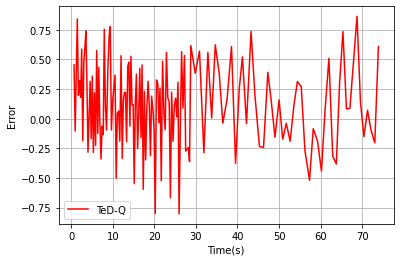

In [12]:
plt.plot(timeList, energyList, 'r-', label="TeD-Q")
plt.xlabel('Time(s)')
plt.grid()
plt.ylabel('Error')
# plt.gca().set_yscale('log')
plt.legend()
print("time: ", time_end-time_start)

In [13]:
result = {}
for i_iter in range(n_search):
    circDefList = []
    compiledCircList = []
    weightList = []
    selectedAIdList = np.random.randint(0, len(NAS_search_space), (n_layers,)).tolist()
    
    circ, fciE = initCircuit(distance, circDefList)
    
#     find optimal expert
    for i in range(n_experts):
        # get params
        params = []
        min_loss = 100000
        min_expert_id = 0
        params = modelParam.get_params(selectedAIdList, i)

        exp = 0
        for idx, circDef in enumerate(circDefList):   
            psi_H_psi = circ(modelParam.params, circDef, selectedAIdList)
            exp += psi_H_psi.real*weightList[idx].real
        loss = exp
        if loss<min_loss:
            min_loss = loss
            min_expert_id = i
    expert_idx = min_expert_id
    # get params
    params = []
    params = modelParam.get_params(selectedAIdList, expert_idx) 
    
    # for each set
    exp = 0
    for idx, circDef in enumerate(circDefList):   
        psi_H_psi = circ(modelParam.params, circDef, selectedAIdList)
        exp += psi_H_psi.real*weightList[idx].real

        
#     print(params)
    print(i_iter, selectedAIdList, fciE, exp.item())
    
    result['-'.join([str(x) for x in selectedAIdList])] = min_loss
    
time_end=time.time()

0 [26, 116, 76] -1.1266988216513705 -0.04615692383084234
1 [40, 87, 38] -1.1266988216513705 0.21652540718461505
2 [91, 124, 26] -1.1266988216513705 -0.2782934694489181
3 [20, 35, 111] -1.1266988216513705 0.0305974197960346
4 [62, 26, 85] -1.1266988216513705 0.7555713802768651
5 [102, 59, 16] -1.1266988216513705 -0.0134282028534419
6 [33, 45, 29] -1.1266988216513705 0.20963468250470838
7 [14, 126, 61] -1.1266988216513705 0.23611863713242187
8 [81, 49, 15] -1.1266988216513705 0.05366339449552786
9 [78, 69, 41] -1.1266988216513705 -0.14707267325517992
10 [88, 23, 41] -1.1266988216513705 -0.5136328907620594
11 [71, 119, 23] -1.1266988216513705 -0.15154548370747153
12 [103, 75, 24] -1.1266988216513705 -0.11598760797192043
13 [84, 13, 81] -1.1266988216513705 0.41244454129046926
14 [89, 123, 94] -1.1266988216513705 0.3736268506405029
15 [73, 84, 79] -1.1266988216513705 0.3323711328677216
16 [84, 85, 123] -1.1266988216513705 0.5212946370059355
17 [54, 47, 66] -1.1266988216513705 -0.25743142023

145 [110, 50, 92] -1.1266988216513705 -0.2551374566378613
146 [104, 117, 50] -1.1266988216513705 0.4702602564721995
147 [41, 61, 100] -1.1266988216513705 0.025089665621129097
148 [54, 54, 19] -1.1266988216513705 -0.1194173705507715
149 [97, 91, 104] -1.1266988216513705 0.4772786907634151


In [14]:
sorted_result = list(result.items())
sorted_result.sort(key=lambda x: x[1], reverse=True)
for idx, data in enumerate(sorted_result):
    print(idx, data[0],data[1].item())

0 62-21-79 0.9227603208871696
1 47-107-32 0.8680050928810575
2 39-107-27 0.7651863586943453
3 62-26-85 0.7555713802768651
4 11-116-88 0.7294621067831262
5 81-75-109 0.7204874825814361
6 52-122-88 0.6942706987968441
7 127-76-74 0.690641571354859
8 56-55-63 0.6887350762539635
9 24-93-125 0.6636532224522973
10 85-25-63 0.6268743801973391
11 110-45-55 0.6134805405742757
12 46-38-100 0.5724548646655687
13 58-98-26 0.5611975522436796
14 62-69-87 0.5609525382750462
15 10-88-36 0.5414516445334107
16 117-58-5 0.5391633568389601
17 98-118-117 0.522999081350911
18 84-85-123 0.5212946370059355
19 59-96-105 0.5061941529519751
20 124-39-50 0.4997522102413976
21 82-37-102 0.48713490871801435
22 115-8-85 0.47786280297726413
23 97-91-104 0.4772786907634151
24 48-96-53 0.4756170025560775
25 104-117-50 0.4702602564721995
26 70-5-7 0.46884400997802606
27 84-106-55 0.4682277655947279
28 103-45-109 0.44986054943945497
29 19-53-109 0.43045754646017054
30 88-21-63 0.4240023100945589
31 84-13-81 0.412444541290

In [15]:
np.savez('qas_pennylane.npz', t=timeList, e=energyList)